# new code

In [19]:
from dataclasses import dataclass
import torch.nn as nn
import torch
from typing import List
import numpy as np
def static_forward(model, f, f_bc, x):
    """
    Perform the forward pass through the model with simplified feature interaction.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
    
    Returns:
        torch.Tensor: The model's predictions.
    """
    # Process inputs through branches
    y_br1 = model._branch1(f)
    y_br2 = model._branch2(f_bc)
    
    # Combine branch outputs using element-wise multiplication
    y_br = y_br1 * y_br2
    
    # Process trunk input
    y_tr = model._trunk(x)
    
    # Combine branch and trunk outputs using Einstein summation
    y_out = torch.einsum("ij,kj->ik", y_br, y_tr)
    
    return y_out

def static_loss(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the loss between the model's predictions and the true labels using a weighted mean squared error.
    The weights are dynamically computed based on the magnitude of the true labels to emphasize larger errors.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
        y: True labels.
    
    Returns:
        torch.Tensor: The computed weighted loss.
    """
    y_out = model.forward(f, f_bc, x)
    # Compute weights based on the magnitude of the true labels
    weights = torch.abs(y) + 1.0  # Add 1 to avoid zero weights
    # Compute weighted mean squared error
    loss = (weights * (y_out - y)**2).mean()
    return loss

def static_init(model: nn.Module, branch1_dim: List[int], branch2_dim: List[int], trunk_dim: List[int]) -> None:
    """
    Initialize the model's parameters and architecture with enhanced flexibility and efficiency.
    
    Args:
        model: The neural network model.
        branch1_dim: Dimensions for the first branch.
        branch2_dim: Dimensions for the second branch.
        trunk_dim: Dimensions for the trunk.
    """
    model.z_dim = trunk_dim[-1]

    # Build branch net for branch1 with residual connections
    modules = []
    in_channels = branch1_dim[0]
    for i, h_dim in enumerate(branch1_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == branch1_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._branch1 = nn.Sequential(*modules)

    # Build branch net for branch2 with residual connections
    modules = []
    in_channels = branch2_dim[0]
    for i, h_dim in enumerate(branch2_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == branch2_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._branch2 = nn.Sequential(*modules)

    # Build trunk net with residual connections
    modules = []
    in_channels = trunk_dim[0]
    for i, h_dim in enumerate(trunk_dim[1:]):
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        if i > 0 and h_dim == trunk_dim[i]:  # Add residual connection if dimensions match
            modules.append(nn.Linear(h_dim, h_dim))
        in_channels = h_dim
    model._trunk = nn.Sequential(*modules)

# old code

In [13]:
import torch
import torch.nn as nn
from typing import List, Tuple

def static_loss(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the loss between the model's predictions and the true labels.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
        y: True labels.
    
    Returns:
        torch.Tensor: The computed loss.
    """
    y_out = model.forward(f, f_bc, x)
    loss = ((y_out - y)**2).mean()
    return loss

def static_forward(model: nn.Module, f: torch.Tensor, f_bc: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Perform the forward pass through the model.
    
    Args:
        model: The neural network model.
        f: Input tensor for the first branch.
        f_bc: Input tensor for the second branch.
        x: Input tensor for the trunk.
    
    Returns:
        torch.Tensor: The model's predictions.
    """
    y_br1 = model._branch1(f)
    y_br2 = model._branch2(f_bc)
    y_br = y_br1 * y_br2

    y_tr = model._trunk(x)
    y_out = torch.einsum("ij,kj->ik", y_br, y_tr)
    return y_out

def static_init(model: nn.Module, branch1_dim: List[int], branch2_dim: List[int], trunk_dim: List[int]) -> None:
    """
    Initialize the model's parameters and architecture.
    
    Args:
        model: The neural network model.
        branch1_dim: Dimensions for the first branch.
        branch2_dim: Dimensions for the second branch.
        trunk_dim: Dimensions for the trunk.
    """
    model.z_dim = trunk_dim[-1]

    # Build branch net for branch1
    modules = []
    in_channels = branch1_dim[0]
    for h_dim in branch1_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._branch1 = nn.Sequential(*modules)

    # Build branch net for branch2
    modules = []
    in_channels = branch2_dim[0]
    for h_dim in branch2_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._branch2 = nn.Sequential(*modules)

    # Build trunk net
    modules = []
    in_channels = trunk_dim[0]
    for h_dim in trunk_dim[1:]:
        modules.append(nn.Sequential(
            nn.Linear(in_channels, h_dim),
            nn.Tanh()
        ))
        in_channels = h_dim
    model._trunk = nn.Sequential(*modules)



# Network structure

In [20]:
class opnn(torch.nn.Module):
        def __init__(self, branch1_dim, branch2_dim, trunk_dim):
            super(opnn, self).__init__()
            static_init(self,branch1_dim, branch2_dim, trunk_dim)

        def forward(self, f, f_bc, x):
            return static_forward(self,f, f_bc, x)
        
        def loss(self, f, f_bc, x, y):
            return static_loss(self, f, f_bc, x, y)
        
torch.cuda.empty_cache()

# parameter setting

In [21]:
PODMode = 10
num_bc = 68 #204
dim_br1 = [PODMode*2, 100, 100, 100]
dim_br2 = [num_bc, 150, 150, 150, 100] #150
dim_tr = [2, 100, 100, 100]

# run main

In [ ]:
import os
import torch
import time
import numpy as np
import scipy.io as io
import math

from tqdm import tqdm
from scipy.interpolate import Rbf
# from scipy.interpolate import interp2d
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import argparse

# def ParseArgument():
#     parser = argparse.ArgumentParser(description='DeepONet')
#     parser.add_argument('--epochs', type=int, default=50000, metavar='N',
#                         help = 'number of epochs to train (default: 1000)')
#     parser.add_argument('--device', type=str, default='cuda', metavar='N',
#                         help = 'computing device (default: GPU)')
#     # parser.add_argument('--save-step', type=int, default=10000, metavar='N',
#     #                     help = 'save_step (default: 10000)')
#     parser.add_argument('--restart', type=int, default=0, metavar='N',
#                         help = 'if restart (default: 0)')
#     # parser.add_argument('--test_model', type=int, default=0, metavar='N',
#     #                     help = 'default training, testing as 1')

#     args = parser.parse_args()
#     return args

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def static_main(model, epochs, device):
    ## hyperparameters
    #args = ParseArgument()
    # epochs = 50000
    # device = 'cuda'
    # save_step = args.save_step
    # test_model = args.test_model
    # if test_model == 1:
    #     load_path = "problems\DIMON\model.pt"

    PODMode = 10
    num_bc = 68 #204
    skip = 3
    dim_br1 = [PODMode*2, 100, 100, 100]
    dim_br2 = [num_bc, 150, 150, 150, 100] #150
    dim_tr = [2, 100, 100, 100]
    # lmd = 0 #1e-6

    num_train = 3300 ## assume 1000+500
    num_test = 200 ## note mesh coordinate in Laplace_test.mat save #900-909 
    # num_cases = num_train + num_test
    
    ## create folders
    # dump_train = './Predictions/Train/'
    # dump_test = './Predictions/Test/'
    model_path = 'Laplace\plot_data\model.pt'
    # os.makedirs(dump_train, exist_ok=True)
    # os.makedirs(dump_test, exist_ok=True)
    # os.makedirs('CheckPts', exist_ok=True)
    ## dataset main
#/root/AEL-P-SNE/outputs/dimon-PDE/2025-01-12_21-58-08
    datafile ="Laplace/dataset/Laplace_data.mat"
    dataset = io.loadmat(datafile)

    x = dataset["x_uni"]
    x_mesh = dataset["x_mesh_data"]
    dx = x_mesh - x ## shape: num_case, num_points, num_dim
    u = dataset["u_data"]
    u_bc = dataset["u_bc"]
    u_bc = u_bc[:, ::skip]

    ## dataset supp
    datafile_supp = "Laplace/dataset/Laplace_data_supp.mat"
    dataset_supp = io.loadmat(datafile_supp)

    x_mesh_supp = dataset_supp["x_mesh_data"]
    dx_supp = x_mesh_supp - x ## shape: num_case, num_points, num_dim
    u_supp = dataset_supp["u_data"]
    u_bc_supp = dataset_supp["u_bc"]
    u_bc_supp = u_bc_supp[:, ::skip]

    ## dataset supp 2
    datafile_supp2 = "Laplace/dataset/Laplace_data_supp2000.mat"
    dataset_supp2 = io.loadmat(datafile_supp2)

    x_mesh_supp2 = dataset_supp2["x_mesh_data"]
    dx_supp2 = x_mesh_supp2 - x ## shape: num_case, num_points, num_dim
    u_supp2 = dataset_supp2["u_data"]
    u_bc_supp2 = dataset_supp2["u_bc"]
    u_bc_supp2 = u_bc_supp2[:, ::skip]

    # mesh_coords_supp2 = dataset_supp2["mesh_coords"][0]
    # mesh_cells_supp2 = dataset_supp2["mesh_cells"][0]

    ## concat
    x_mesh = np.concatenate((x_mesh, x_mesh_supp, x_mesh_supp2), axis=0)
    dx = np.concatenate((dx, dx_supp, dx_supp2), axis=0)
    u = np.concatenate((u, u_supp, u_supp2), axis=0)
    u_bc = np.concatenate((u_bc, u_bc_supp, u_bc_supp2), axis=0)
    
    ## SVD
    dx_train = dx[:num_train]
    dx_test = dx[-num_test:]
    
    ## coefficient for training data
    dx1_train = dx_train[:, :, 0]
    dx2_train = dx_train[:, :, 1]

    pca_x = PCA(n_components=PODMode)
    pca_x.fit(dx1_train - dx1_train.mean(axis=0))
    coeff_x_train = pca_x.transform(dx1_train - dx1_train.mean(axis=0))
    coeff_x_test = pca_x.transform(dx_test[:, :, 0] - dx1_train.mean(axis=0))

    pca_y = PCA(n_components=PODMode)
    pca_y.fit(dx2_train - dx2_train.mean(axis=0))
    coeff_y_train = pca_y.transform(dx2_train - dx2_train.mean(axis=0))
    coeff_y_test = pca_y.transform(dx_test[:, :, 1] - dx2_train.mean(axis=0))
    

    f_train = np.concatenate((coeff_x_train, coeff_y_train), axis=1)
  
    ## coeffiient for testing data
    f_test = np.concatenate((coeff_x_test, coeff_y_test), axis=1)

    ##########################
    u_train = u[:num_train]
    u_test = u[-num_test:]
    f_bc_train = u_bc[:num_train, :]
    f_bc_test = u_bc[-num_test:, :]

    ## tensor
    u_test_tensor = torch.tensor(u_test, dtype=torch.float).to(device)
    f_test_tensor = torch.tensor(f_test, dtype=torch.float).to(device)
    f_bc_test_tensor = torch.tensor(f_bc_test, dtype=torch.float).to(device)

    u_train_tensor = torch.tensor(u_train, dtype=torch.float).to(device)
    f_train_tensor = torch.tensor(f_train, dtype=torch.float).to(device)
    f_bc_train_tensor = torch.tensor(f_bc_train, dtype=torch.float).to(device)

    x_tensor = torch.tensor(x, dtype=torch.float).to(device)

    ## initialization
    # model = model(dim_br1, dim_br2, dim_tr).to(device)
    model=model.to(device)
    model = model.float()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    
    train_loss = np.zeros((50000, 1))
    # test_loss = np.zeros((args.epochs, 1))
    # rel_l2_err_his = np.zeros((args.epochs, 1))

    flag = 1
    ## training
    if flag:
        def train(epoch, f, f_bc, x, y):
            model.train()
            def closure():
                optimizer.zero_grad()

                ## L2 regularization
                # regularization_loss = 0
                # for param in model._branch.parameters():
                #     regularization_loss += torch.sum(param**2)
                # for param in model._trunk.parameters():
                #     regularization_loss += torch.sum(param**2)
                #for param in model._out_layer.parameters():
                #    regularization_loss += torch.sum(param**2)

                loss = model.loss(f, f_bc, x, y)
                train_loss[epoch, 0] = loss

                loss.backward()
                return loss
            optimizer.step(closure)

        ## Iterations
        # print('start training...', flush=True)
        # tic = time.time()
        for epoch in tqdm(range(0, epochs), desc='Epoch: 0', unit='epoch', leave=True):
            if epoch == 10000:
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
            elif epoch == 90000:
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
            elif epoch == epochs - 1000:
                optimizer = torch.optim.LBFGS(model.parameters())

            ## Training
            train(epoch, f_train_tensor, f_bc_train_tensor, x_tensor, u_train_tensor)
            ## Testing
            loss_tmp = to_numpy(model.loss(f_test_tensor, f_bc_test_tensor, x_tensor, u_test_tensor))
            #test_loss[epoch, 0] = loss_tmp

            ## testing error
            #if epoch%100 == 0:
                #print(f'Epoch: {epoch}, Train Loss: {train_loss[epoch, 0]:.6f}, Test Loss: {test_loss[epoch, 0]:.6f}', flush=True)
                
            # ## Save model
            if (epoch+1)%epochs == 0: 
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)

    else:
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    # toc = time.time()

    ##
    u_test_pred = to_numpy(model.forward(f_test_tensor, f_bc_test_tensor, x_tensor))
    # l2_err_test = ((u_test_pred - u_test)**2).mean(axis=1)
    u_train_pred = to_numpy(model.forward(f_train_tensor, f_bc_train_tensor, x_tensor))
    # l2_err_train = ((u_train_pred - u_train)**2).mean(axis=1)

    rel_l2_err_train = (np.linalg.norm(u_train_pred - u_train, axis=1)/np.linalg.norm(u_train, axis=1))
    # rel_l2_err_test = (np.linalg.norm(u_test_pred - u_test, axis=1)/np.linalg.norm(u_test, axis=1))


    # print(f'total training time: {int((toc-tic)/60)} min', flush=True)
    '''
    np.savetxt('./train_loss.txt', train_loss)
    np.savetxt('./test_loss.txt', test_loss)
    np.savetxt('./rel_l2_test_his.txt', rel_l2_err_his)
    np.savetxt('./l2_err_test.txt', l2_err_test)
    np.savetxt('./l2_err_train.txt', l2_err_train)

    np.savetxt('./rel_l2_err_test.txt', rel_l2_err_test)
    np.savetxt('./rel_l2_err_train.txt', rel_l2_err_train)
    '''

    ## save train
    u_train_pred = model.forward(f_train_tensor, f_bc_train_tensor, x_tensor)
    u_pred = to_numpy(u_train_pred)
    u_true = u_train
        
    ##############
    ## save test
    u_test_pred = model.forward(f_test_tensor, f_bc_test_tensor, x_tensor)
    u_pred = to_numpy(u_test_pred)
    u_true = u_test
    # u_pred_save = []
    # abs_err_pred_save = []

    ## MSE err
    mean_abs_err = (abs(u_pred - u_true)).mean(axis=1)
    # print(mean_abs_err)

    rel_l2_err = np.linalg.norm(u_test - u_pred, axis=1)/np.linalg.norm(u_test, axis=1)
                        # np.mean()
    #np.savetxt("mean_abs_err_dimon_200.txt", mean_abs_err)
    #np.savetxt("rel_l2_err_dimon_200.txt", rel_l2_err)


    # if test_model == 1:
    #     # num2test ## 1500 in total and 

    #     save_lib = {}
    #     save_lib["u_pred_canonical_plot"] = u_pred_save
    #     save_lib["abs_err_pred_save"] = abs_err_pred_save
    #     save_lib["x_canonical"] = x
    #     save_lib["u_pred"] = u_pred
    #     save_lib["u_true"] = u_true

    #     save_lib["x_mesh"] = x_mesh_supp2[-num_test:]
    #     save_lib["mesh_coords"] = dataset_supp2["mesh_coords"][0][-num_test:]
    #     save_lib["mesh_cells"] = dataset_supp2["mesh_cells"][0][-num_test:]

    #     io.savemat("model_pred_vis.mat", save_lib)

    return mean_abs_err,rel_l2_err,rel_l2_err_train,x_mesh,u_pred,u_true

In [11]:
mean_abs_err,rel_l2_err=static_main(opnn(dim_br1, dim_br2, dim_tr), 50000, 'cuda')

In [18]:

print("mean_abs_err:")
print(mean_abs_err.mean())

print("rel_l2_err:")
print(rel_l2_err.mean())



mean_abs_err:
0.007533173922294954
rel_l2_err:
0.016229752385415623


# mae
ours
mean_abs_err:
3.2e-3
rel_l2_err:
6.4e-3



Text(0.5, 0, ' Mean Abs. Err. , log scale (n=200)')

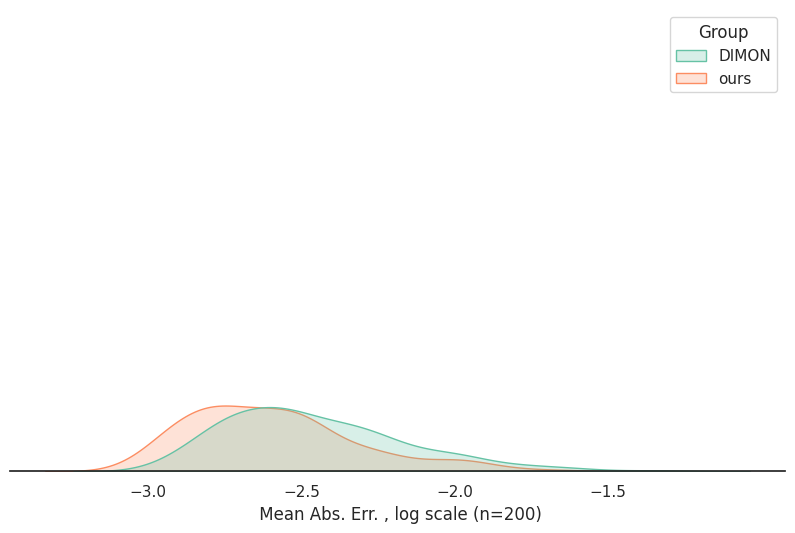

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [float(line.strip()) for line in lines]
    return data


def log_with_base(x, base):
    return np.log(x) / np.log(base)


file_path_group1 = 'Laplace\plot_data\mean_abs_err_dimon_200.txt'
file_path_group2 = 'Laplace\plot_data\mean_abs_err_ours_200.txt'

data_group1 = load_data(file_path_group1)
data_group2 = load_data(file_path_group2)

log_base = 10

log_data_group1 = log_with_base([x if x > 0 else 1e-100 for x in data_group1], log_base)
log_data_group2 = log_with_base([x if x > 0 else 1e-100 for x in data_group2], log_base)

df_group1 = pd.DataFrame(log_data_group1, columns=['Log_Value'])
df_group1['Group'] = 'DIMON'

df_group2 = pd.DataFrame(log_data_group2, columns=['Log_Value'])
df_group2['Group'] = 'ours'

df_combined = pd.concat([df_group1, df_group2], ignore_index=True)

sns.set(style="white")

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_combined, x='Log_Value', hue='Group', fill=True, common_norm=False, palette='Set2')

plt.ylim(0, 10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(np.arange(-3.0, -1.0, 0.5))

plt.yticks([])
ax.set_yticklabels([])
ax.yaxis.set_visible(False)

ax.set_xlabel(' Mean Abs. Err. , log scale (n=200)')


# l2

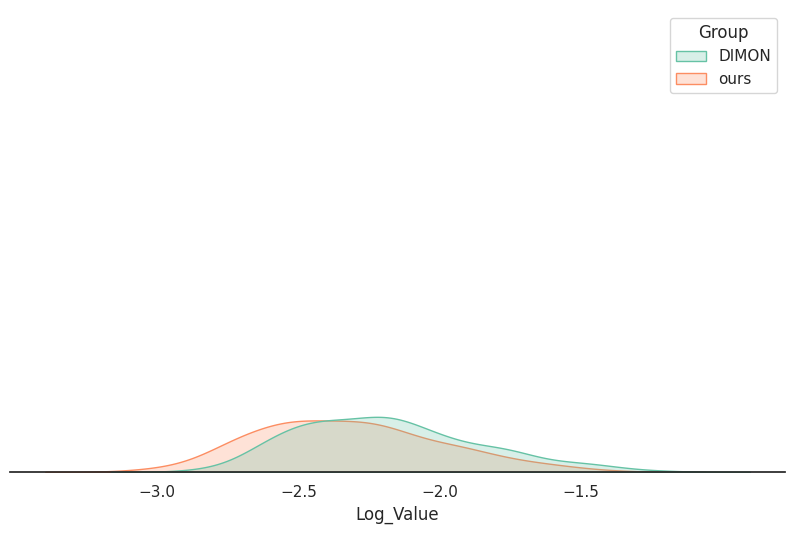

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [float(line.strip()) for line in lines]
    return data

def log_with_base(x, base):
    return np.log(x) / np.log(base)

file_path_group1 = 'Laplace/plot_data/rel_l2_err_dimon_200.txt'
file_path_group2 = 'rel_l2_err_ours_200.txt'

data_group1 = load_data(file_path_group1)
data_group2 = load_data(file_path_group2)


log_base = 10  


log_data_group1 = log_with_base([x if x > 0 else 1e-100 for x in data_group1], log_base)
log_data_group2 = log_with_base([x if x > 0 else 1e-100 for x in data_group2], log_base)


df_group1 = pd.DataFrame(log_data_group1, columns=['Log_Value'])
df_group1['Group'] = 'DIMON'

df_group2 = pd.DataFrame(log_data_group2, columns=['Log_Value'])
df_group2['Group'] = 'ours'


df_combined = pd.concat([df_group1, df_group2], ignore_index=True)


sns.set(style="white")


plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_combined, x='Log_Value', hue='Group', fill=True, common_norm=False, palette='Set2')

plt.ylim(0, 10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(np.arange(-3.0, -1.0, 0.5))

plt.yticks([]) 
ax.set_yticklabels([])
ax.yaxis.set_visible(False)

# figure2_e

In [217]:
mean_abs_err,rel_l2_err,qq=static_main(opnn(dim_br1, dim_br2, dim_tr), 50000, 'cuda')

In [218]:
print(rel_l2_err.mean())
print(qq.mean())

0.010538069624355412
0.005742549603479637


rel_l2_err_64:
test:0.456652233545402
train:0.003796377492580931

rel_l2_err__ours_64:
test:0.7053123365753526
train:0.005736974864496283

rel_l2_err_128:
test:0.3057313514096041
train:0.005805526700830862

rel_l2_err__ours_128:
test:0.262426694967099
train:0.006367774343030246

rel_l2_err_256:
test:0.13098631307251926
train:0.006094000425042994

rel_l2_err_ours_256:
test:0.0846756527446324
train:0.008407707176811234

rel_l2_err_512:
test:0.05395135255467819
train:0.007194937259064209

rel_l2_err_ours_512:
test:0.023700086154803118
train:0.006341353846649782

rel_l2_err_1024:
test:0.01978413230616029
train:0.006527728910212888

rel_l2_err_ours_1024:
test:0.010538069624355412
train:0.005742549603479637

/tmp/ipykernel_1809/94659674.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0,top=5e-1)


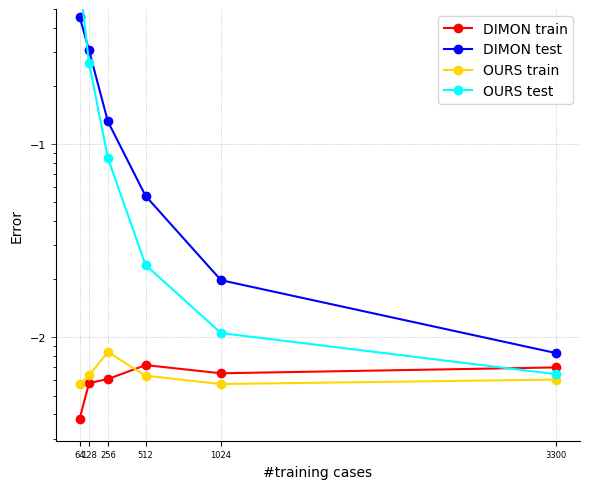

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

axis_all = [64,128,256,512,1024,3300]
dimon_train = [0.003796377492580931,0.005805526700830862,0.006094000425042994,0.007194937259064209,0.006527728910212888,7e-3]
dimon_test = [0.456652233545402,0.3057313514096041,0.13098631307251926,0.05395135255467819,0.01978413230616029,8.3e-3]

ours_train = [0.005736974864496283,0.006367774343030246,0.008407707176811234,0.006341353846649782,0.005742549603479637,0.00605619296290941]
ours_test = [0.7053123365753526,0.262426694967099,0.0846756527446324,0.023700086154803118,0.010538069624355412,0.00645619296290941]

fig, ax = plt.subplots(figsize=(6,5))


ax.plot(axis_all, dimon_train, ls = '-',color = 'red',marker = 'o', label='DIMON train')
ax.plot(axis_all, dimon_test, ls = '-', color = 'blue', marker = 'o', label='DIMON test')
ax.plot(axis_all, ours_train, ls = '-', color = '#FFD700', marker = 'o', label='OURS train')
ax.plot(axis_all, ours_test, ls = '-', color = 'cyan', marker = 'o', label='OURS test')

ax.set_yscale('log')

ax.set_xticks(axis_all)

formatter = ticker.LogFormatterExponent(labelOnlyBase=False, minor_thresholds=(1, 1))
ax.yaxis.set_major_formatter(formatter)

ax.set_ylim(bottom=0,top=5e-1)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel("#training cases")
plt.ylabel("Error")

ax.tick_params(axis='y', which='major', width=0.5, labelsize=8)
ax.grid(ls=':', lw=0.5) 
ax.tick_params(axis='x', which='major', labelsize=6)

ax.legend(loc='best', fontsize=10)


plt.tight_layout()
plt.grid(ls = ':')
plt.show()

# figure2_c

In [23]:
mean_abs_err,rel_l2_err,rel_l2_err_train,x_mesh,u_pred,u_true=static_main(opnn(dim_br1, dim_br2, dim_tr), 50000, 'cuda')

Epoch: 0: 100%|██████████| 50000/50000 [10:52<00:00, 76.67epoch/s] 


In [24]:
print(mean_abs_err.mean())
print(rel_l2_err.mean())

0.003987371400741406
0.008197191459853436


In [ ]:
for i in range(0, 10):
    u_pred_plot = u_pred[i]
    u_true_plot = u_true[i]
    x_coord = x_mesh[i]

    print(f"printing training case: {i}")

    ## figure
    fig = plt.figure(constrained_layout=False, figsize=(15, 5))
    gs = fig.add_gridspec(1, 3)

    for j, (data, title) in enumerate(zip(
            [u_true_plot, u_pred_plot, abs(u_true_plot - u_pred_plot)],
            ["True data", "prediction", "err"])):
        ax = fig.add_subplot(gs[j])
        h = ax.scatter(x_coord[:, 0], x_coord[:, 1], c=data)
        
      
        cbar = plt.colorbar(h)
        cbar.ax.tick_params(labelsize=10)  
        

        for label in cbar.ax.get_yticklabels():
            label.set_fontproperties(font)

        ax.set_aspect(1)
        ax.set_title(title, fontproperties=font, fontsize=17)

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(font)
            label.set_fontsize(10)  

    fig.savefig("ours_case_" + str(i) + "_img.png")
    plt.close()

printing training case: 0
printing training case: 1
printing training case: 2
printing training case: 3
printing training case: 4
printing training case: 5
printing training case: 6
printing training case: 7
printing training case: 8
printing training case: 9
